In [1]:
import pandas as pd
df = pd.read_csv("nike_mens_clothing_with_additional_data.csv")

In [2]:
df.head()

,Title,Details,Image URL,Product URL,Description,Price
0,Nike Sportswear Premium Essentials,Men's T-Shirt,"https://static.nike.com/a/images/c_limit,w_592...",https://www.nike.com/t/sportswear-premium-esse...,NaN,NaN
1,Nike Club,Men's Cargo Pants,"https://static.nike.com/a/images/c_limit,w_592...",https://www.nike.com/t/club-mens-cargo-pants-R...,NaN,NaN
2,Nike Solo Swoosh,Men's Full-Zip Hoodie,"https://static.nike.com/a/images/c_limit,w_592...",https://www.nike.com/t/solo-swoosh-mens-full-z...,NaN,NaN
3,Nike Club,Men's Flow Shorts,"https://static.nike.com/a/images/c_limit,w_592...",https://www.nike.com/t/club-mens-flow-shorts-P...,NaN,NaN
4,Nike Primary,Men's Dri-FIT UV Full-Zip Versatile Hoodie,"https://static.nike.com/a/images/c_limit,w_592...",https://www.nike.com/t/primary-mens-dri-fit-uv...,NaN,NaN


In [6]:

import os
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import CLIPProcessor, CLIPModel
from pinecone import Pinecone
from dotenv import load_dotenv
load_dotenv()

pc = Pinecone(
    api_key="2ba6994a-abc0-4337-a38e-82aaaab00815",
)
# Connect to the index
index_name = "nike-inventory-storage"
index = pc.Index(index_name)

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define function to get image embedding
def get_image_embedding(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    inputs = processor(images=img, return_tensors="pt", padding=True)
    with torch.no_grad():
        embeddings = model.get_image_features(**inputs).numpy().flatten()
    return embeddings

# Define function to get image embedding from a local file
def get_image_embedding_local(image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt", padding=True)
    with torch.no_grad():
        embeddings = model.get_image_features(**inputs).numpy().flatten()
    return embeddings

# Function to search by local image
def search_by_image_local(image_path):
    embedding = get_image_embedding_local(image_path)
    result = index.query([embedding.tolist()], top_k=10)
    return result

# Define function to get text embedding
def get_text_embedding(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True)
    with torch.no_grad():
        embeddings = model.get_text_features(**inputs).numpy().flatten()
    return embeddings

# Function to search by image
def search_by_image(image_url,n):
    embedding = get_image_embedding(image_url)
    result = index.query(vector=embedding.tolist(), top_k=n,include_metadata=True)
    return result

# Function to search by text
def search_by_text(text,n):
    embedding = get_text_embedding(text)
    result = index.query(vector=embedding.tolist(), top_k=n,include_metadata=True)
    return result

# # Search by image
# print("Searching by image...")
# image_search_results = search_by_image_local(image_url)
# for match in image_search_results.matches:
#     print(f"ID: {match.id}, Score: {match.score}, Metadata: {match.metadata}")

import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Load the CSV file

# Function to display image based on ID from CSV
def display_image_by_id(match):
    #df = pd.read_csv('nike_mens_clothing_with_additional_data.csv')
    # Get the image URL from the CSV based on the ID
    #row = df.iloc[image_id]
    #image_url = row['Image URL']
    #print(match.metadata)
    image_url=match.metadata['Image URL']
    print(image_url)
    #Load and display the image
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Title: {match.metadata['Title']}\nDetails: {match.metadata['Details']}\nDescription: {match.metadata['Description']}\nPrice: {match.metadata['Price']}")
    plt.show()

/home/snehilaryan/prompt-final/prompt-final-project/myenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/465c3e6e-2584-480a-b109-68411ad1dce8/kd-mens-dri-fit-standard-issue-reversible-basketball-shorts-kWqrCX.png


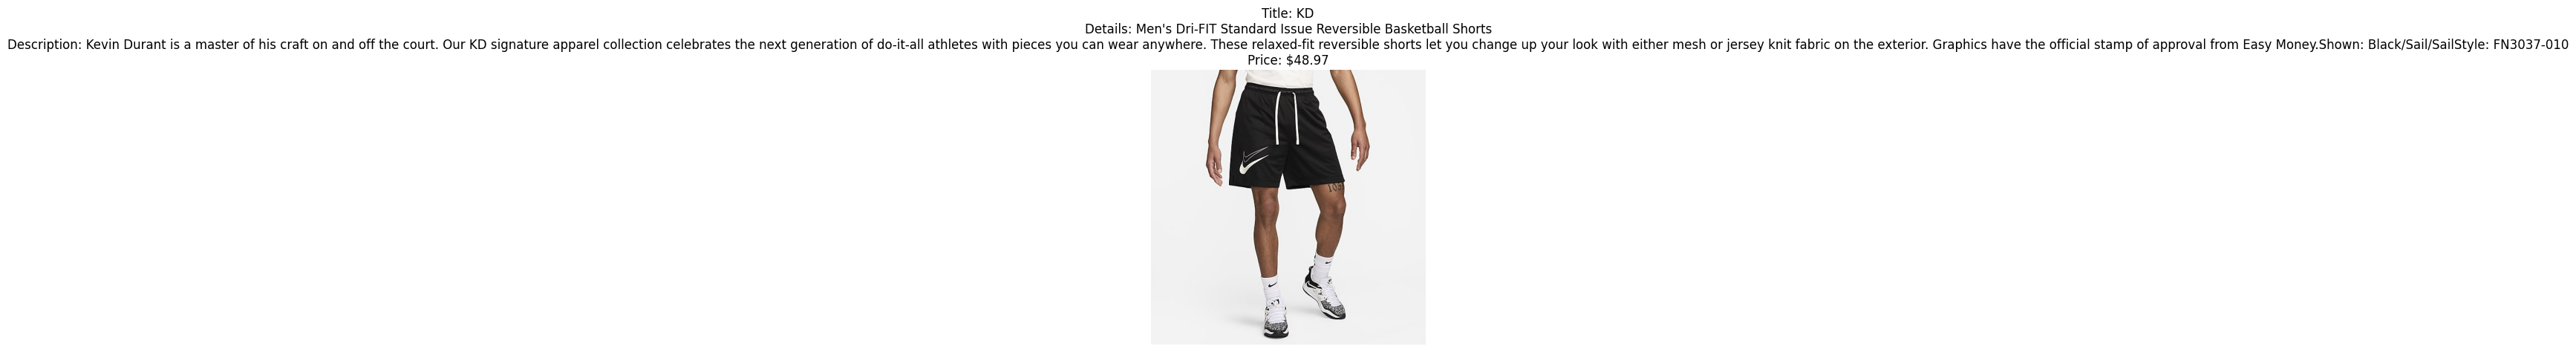

https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/59e2c424-d12d-4cb1-8f88-23480b57c2a5/sportswear-tech-fleece-mens-shorts-jbdtpn.png


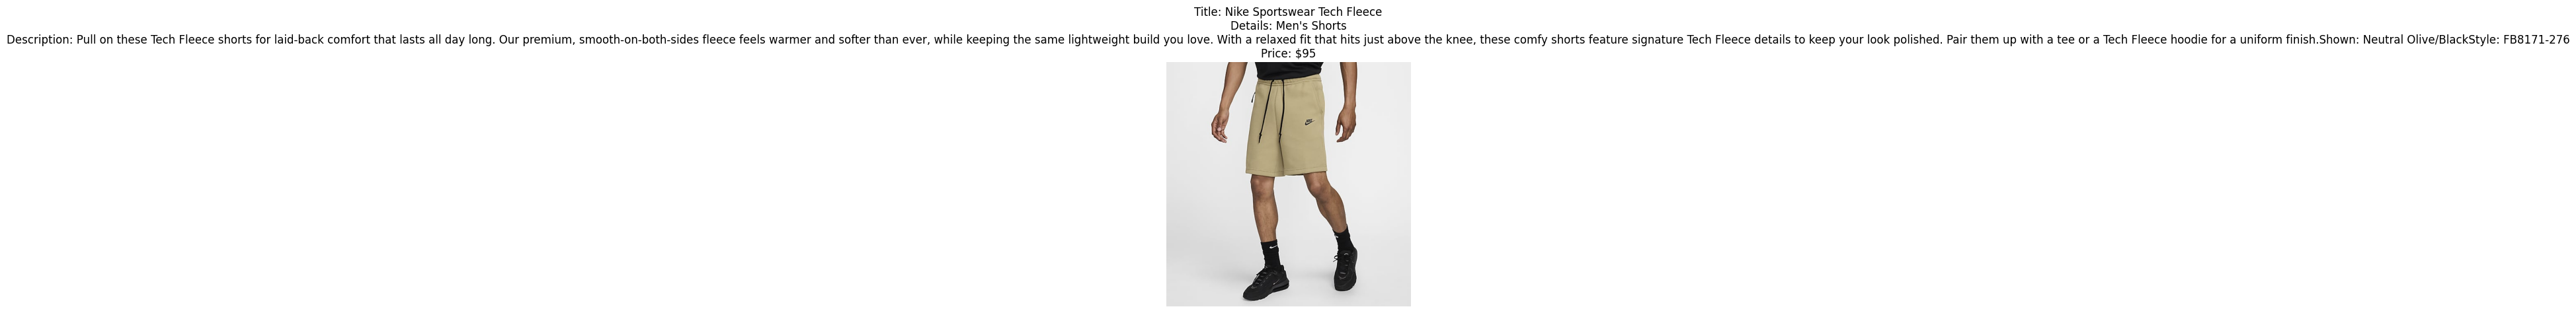

https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/b8bf902f-de19-4ad9-bea8-87aa4d1f5679/unlimited-mens-dri-fit-7-unlined-versatile-shorts-HX9Jjq.png


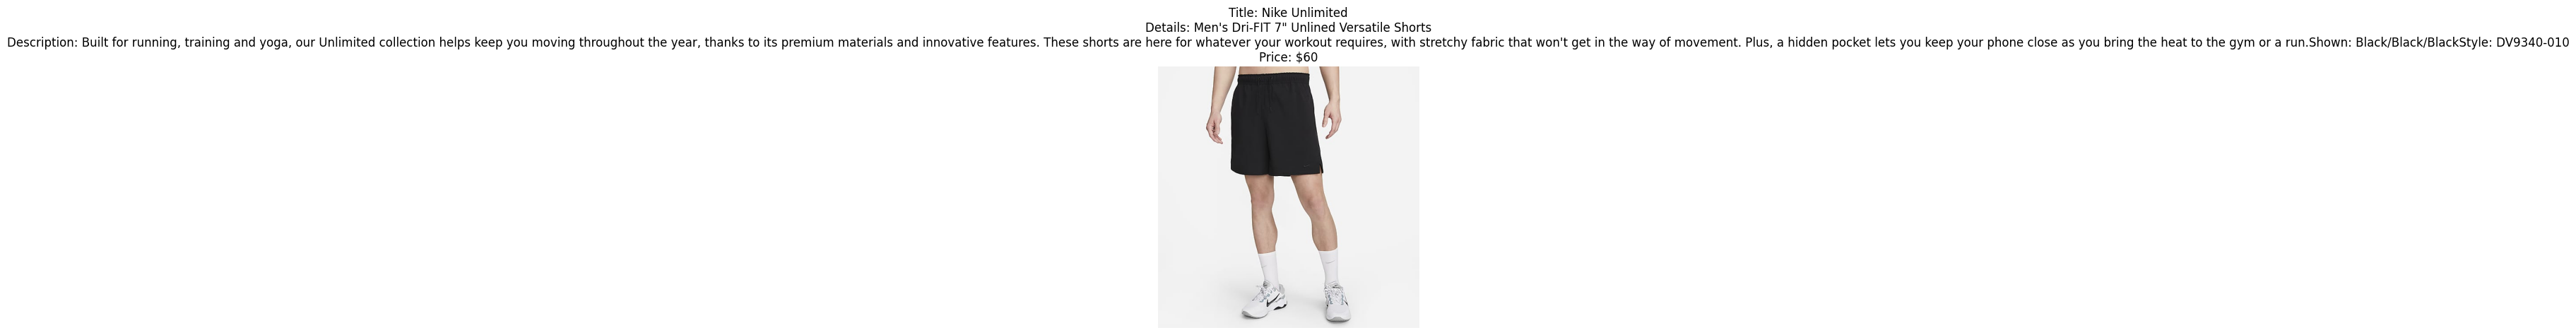

https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/44ae7fca-0b79-4603-b888-f19a0c8dc623/club-mens-flow-shorts-PsQ5w3.png


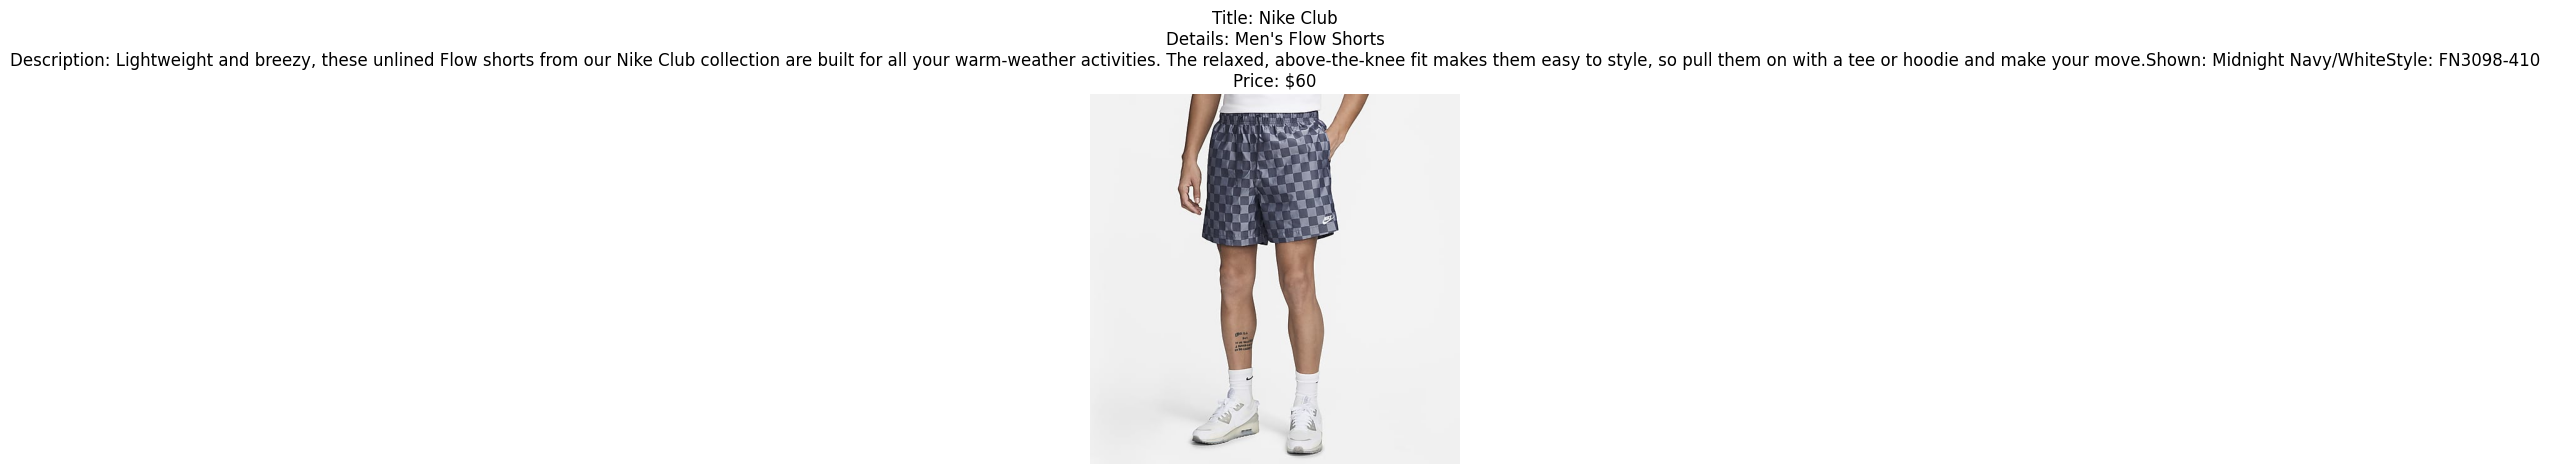

https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/276f1761-fa58-4255-a492-cd573386a245/sportswear-club-mens-graphic-shorts-hQgvng.png


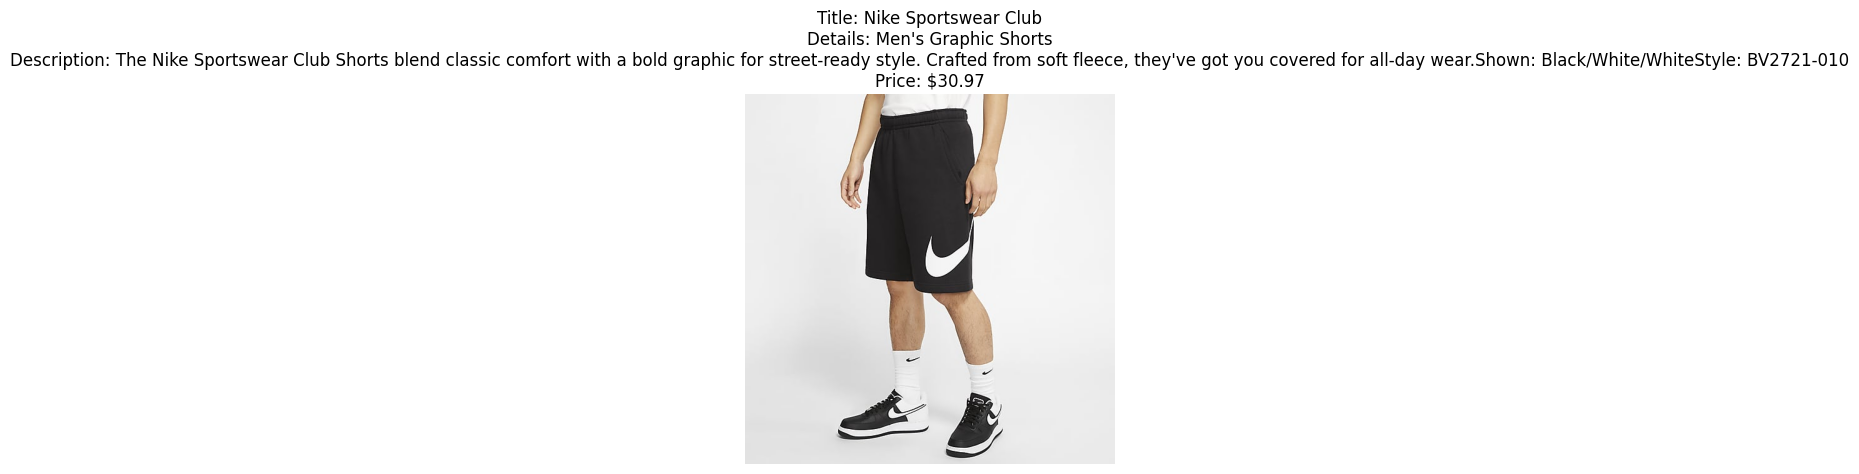

In [11]:
text_query = "Black Shorts"
n_results = 5  # Number of top results to retrieve
text_search_results = search_by_text(text_query, n_results)

# Display the search results
for match in text_search_results.matches:
    display_image_by_id(match)

In [12]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('nike_mens_clothing_with_additional_data_old.csv')

# Remove the first 20 characters from the 'Product URL' column
df['Product URL'] = df['Product URL'].str[20:]

# Display the modified DataFrame (optional)
print(df.head())

# Save the modified DataFrame back to a CSV file (optional)
# df.to_csv('nike_mens_clothing_with_additional_data_modified.csv', index=False)

                                Title                          Details  \
0                           Nike Club            Men's Coaches' Jacket   
1                           Nike Club       Men's Corduroy Chino Pants   
2  Nike Sportswear Premium Essentials                    Men's T-Shirt   
3                           Nike Club          Men's Woven Flow Shorts   
4                        Nike Primary  Men's Dri-FIT UV Versatile Crew   

                                           Image URL  \
0  https://static.nike.com/a/images/c_limit,w_592...   
1  https://static.nike.com/a/images/c_limit,w_592...   
2  https://static.nike.com/a/images/c_limit,w_592...   
3  https://static.nike.com/a/images/c_limit,w_592...   
4  https://static.nike.com/a/images/c_limit,w_592...   

                                         Product URL  \
0  https://www.nike.com/t/club-mens-coaches-jacke...   
1  https://www.nike.com/t/club-mens-corduroy-chin...   
2  https://www.nike.com/t/sportswear-premium-esse.

In [15]:
df.to_csv('nike_mens_clothing_with_additional_data.csv', index=False)

In [13]:
BUCKET_NAME = "prompt-final"
from google.cloud import storage
def upload_blob(source_file_name: str, destination_blob_name: str, bucket_name: str = BUCKET_NAME):
    """Uploads a file to Google Cloud Storage and returns its public URL."""
    try:
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)

        blob.upload_from_filename(source_file_name, if_generation_match=0)
        # logger.info(f"File {source_file_name} uploaded to {destination_blob_name}.")
        
        # blob.make_public()
        return blob.public_url
    except Exception as e:
        # logger.error(f"Error uploading file to GCS: {e}")
        print(f"Error uploading file to GCS: {e}")
        return None

In [14]:
upload_blob("nike_mens_clothing_with_additional_data_old.csv", "nike_mens_clothing_with_additional_data_old.csv")

'https://storage.googleapis.com/prompt-final/nike_mens_clothing_with_additional_data_old.csv'